# Search Parameters

In [1]:
seed = 70 # seed for NMF topic model
num_topics = 12
# query = 'title-abs-key("gut flora" OR "gut microbiota" OR "intestinal bacteria" AND ("neurotransmitter" OR "serotonin" OR "5-HT" OR "dopamine" OR "norepinephrine" OR "GABA"))'
# query = 'title-abs-key("gut flora" OR "gut microbiota" OR "intestinal bacteria" AND ("mental disorder" OR "mood disorder" OR "depression" OR "major depressive disorder" OR "anxiety" OR "eating disorder"))'
# query = 'title-abs-key("neurotransmitter" AND ("GABA" OR "serotonin" OR "5-HT" OR "dopamine" OR "norepinephrine") AND ("mental health" OR "mental disorder" OR "mood disorder" OR "depression" OR "major depressive disorder" OR "eating disorder" OR "anxiety"))'
# query = 'title-abs-key("gut flora" OR "gut microbiota" OR "intestinal bacteria" AND ("mental health" OR "mental disorder" OR "mood disorder" OR "depression" OR "major depressive disorder" OR "eating disorder" OR "anxiety") AND ("GABA" OR "serotonin" OR "5-HT" OR "dopamine" OR "norepinephrine"))'
query = 'title-abs-key("deep learning" AND ("autonomous" OR "self-driving" OR "robotic" OR "driverless" AND ("car" OR "cars" OR "driving")))'
# query = 'title-abs-key("autonomous driving" OR "self-driving car" OR "robotic car" OR "driverless car")'
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
vis_seed = 6 # seed for t-SNE visualization
vis_angle = 135 # rotation angle for visualization

# Import Modules

In [2]:
import random
import gensim
import pybliometrics.scopus as scopus
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction
import ipywidgets as widgets

from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict

import seaborn as sns
sns.set('paper')

import logging
logging.getLogger().setLevel(logging.INFO)

# some python 3 trickery
import sys
if sys.version_info[0] >= 3:
    unicode = str

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
def prepare_fig(w=1, h=None):
    if h is None: h = w
    figsize = (6 * w, 3 * h)
    sns.set(rc={'figure.figsize': figsize})
    fig = plt.figure(figsize=figsize)
    plt.clf()
    return fig

def top_k(mapping, k=10):
    return sorted(mapping.keys(), key=lambda x: mapping[x])[::-1][:k]

pd.set_option('display.max_rows', 250)

# Perform Query

In [4]:
eids = scopus.ScopusSearch(query).get_eids()
random.seed(0)
random.shuffle(eids)

bar = widgets.IntProgress(
    min=0, 
    max=len(eids), 
    description='Loading')
display(bar)

print('query: {} ({} results)'.format(query, len(eids)))

papers = []
for eid in eids:
    papers.append(scopus.AbstractRetrieval(eid, view='FULL'))
    bar.value += 1
    bar.description = str(bar.value)

print('scopus returned {} results'.format(len(papers)))

# Filter on article type
# ar = article, cp = conference proceeding, re = review
print(set([p.srctype for p in papers]))

# Filter on citation type
#papers = [p for p in papers if p.citationType in ('ar', 'cp', 're') or p.citationType is None]

# Filter on date
#papers = [p for p in papers if int(p.coverDate[:4]) <= 2018]

print('{} papers remaining'.format(len(papers)))

IntProgress(value=0, description='Loading', max=1950)

query: title-abs-key("deep learning" AND ("autonomous" OR "self-driving" OR "robotic" OR "driverless" AND ("car" OR "cars" OR "driving"))) (1950 results)
scopus returned 1950 results
{'k', 'p', 'j', 'd', 'b'}
1950 papers remaining


In [5]:
texts = []
for p in papers:
    text = (p.title or '') + ' ' + (p.abstract or '')
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ', text) # Replace punctation by spaces
    texts.append([w for w in text.split(' ') if w]) # Split on spaces, remove empty items

# Analysis

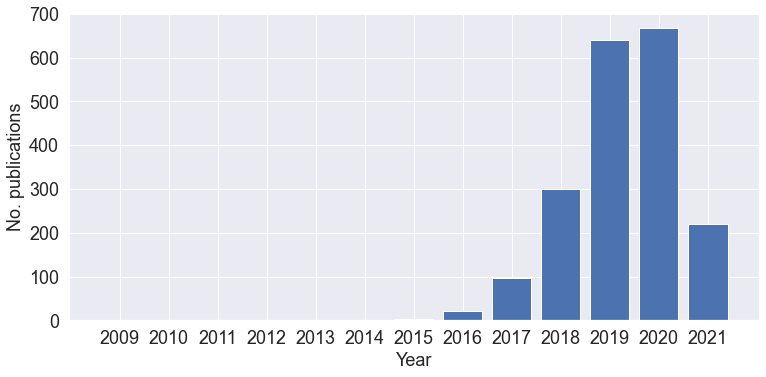

In [6]:
# Publications per year
year_count = defaultdict(int)

for p in papers:
    year_count[int(p.coverDate[:4])] += 1
       
years = range(2009, 2022)

prepare_fig(1.8, 1.8)
plt.ylabel("No. publications",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.bar(
    years,
    [year_count[y] for y in years])
plt.xticks(years);
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig('years_ad.pdf')

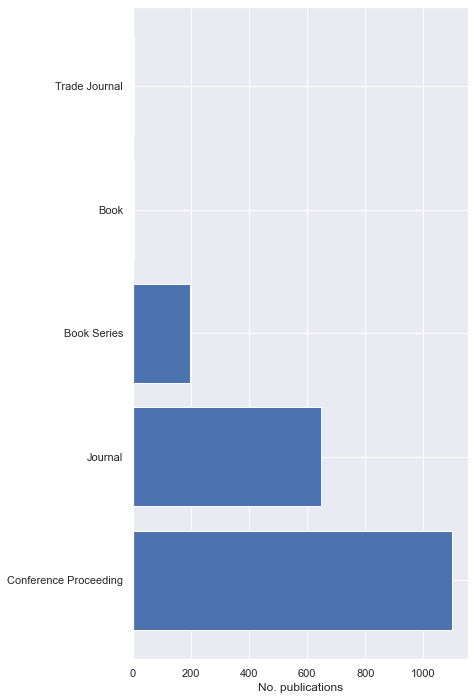

In [7]:
# Publications per aggregation type
def plot_statistic(fun):
    count = defaultdict(int)

    for p in papers:
        for key in fun(p):
            if key:
                count[unicode(key)] += 1

    top_keys = top_k(count, 50)

    prepare_fig(1, 4)
    plt.xlabel("No. publications")
    plt.barh(
        range(len(top_keys)),
        [count[a] for a in top_keys])
    plt.yticks(
        range(len(top_keys)), 
        [key[:50] for key in top_keys])
    plt.show()

plot_statistic(lambda p: [p.aggregationType])

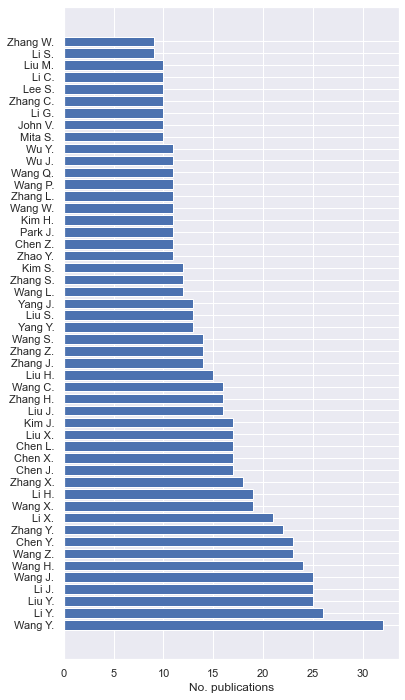

In [8]:
# Publications per author
plot_statistic(lambda p: set(a.indexed_name for a in p.authors or []))

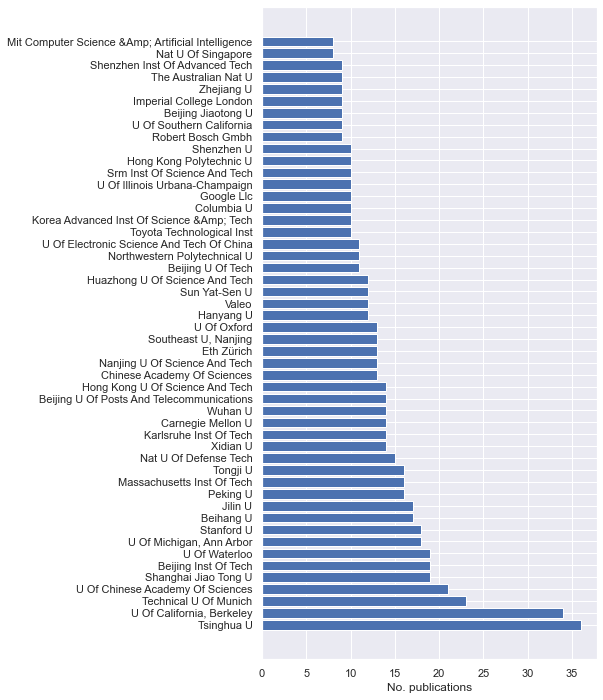

In [9]:
# Publications per institute
def clean_affiliation(name):
    name = unicode(name).title()
    pairs = [
        ['University', 'U'],
        ['Universitat', 'U'],
        ['Laboratories', 'Lab'],
        ['Laboratory', 'Lab'],
        ['National', 'Nat'],
        ['Corporation', 'Corp'],
        ['Technology', 'Tech'],
        ['Institute', 'Inst'],
    ]
    
    for needle, replacement in pairs:
        name = name.replace(needle, replacement)
    return name

plot_statistic(lambda p: set(clean_affiliation(a.name) for a in p.affiliation or []))

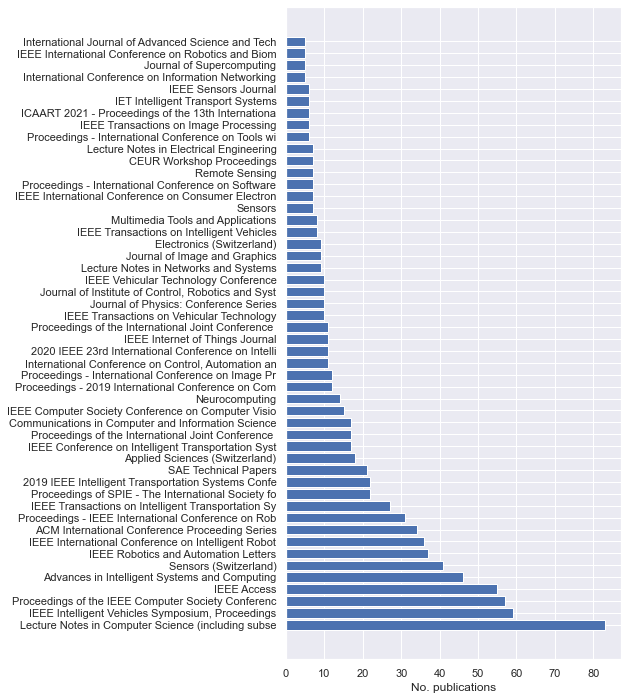

In [10]:
# Publications per publication source, conference/journal (TODO: cleaning!)
plot_statistic(lambda p: [p.publicationName])

# Topic Modeling
## Preprocessing

In [11]:
# Load stopwords, bigrams, and stem rules
try:
    stopwords = set()
    with open('stopwords.txt', 'r') as f:
        stopwords = [w.strip() for w in f if w.strip()]
                
    print('loaded {} stopwords'.format(len(stopwords)))
except Exception as e:
    logging.error('failed to load stopwords.txt: {}'.format(e))

try:
    bigrams = dict()
    with open('bigrams.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b, c = line.split()
                bigrams[a, b] = c
        
    print('loaded {} bigrams'.format(len(bigrams)))
except Exception as e:
    logging.error('failed to load bigrams.txt: {}'.format(e))
    
try:
    stem_rules = dict()
    with open('stemming.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b = line.strip().split()
                stem_rules[a] = b
        
    print('loaded {} stem rules'.format(len(stem_rules)))
except Exception as e:
    logging.error('failed to load stemming.txt: {}'.format(e))

loaded 152 stopwords
loaded 42 bigrams
loaded 2 stem rules


In [12]:
# Print common words
one_count = defaultdict(int)

for text in texts:
    for a in text:
        one_count[a] += 1
        
print('Top words')
display(pd.DataFrame(
    [(w, one_count[w], 'Yes' * (w in stopwords)) for w in top_k(one_count, 250)],
    columns=['word', 'count', 'in stopwords.txt?']))

Top words


,word,count,in stopwords.txt?
0,the,21543,Yes
1,of,12502,Yes
2,and,12297,Yes
3,to,9405,Yes
4,in,8371,Yes
5,a,8247,
6,for,5720,Yes
7,is,4929,Yes
8,learning,4319,
9,on,3978,Yes


In [13]:
# Print common bigrams
two_count = defaultdict(int)

for text in texts:
    for a, b in zip(text, text[1:]):
        if a not in stopwords and b not in stopwords:
            two_count[a, b] += 1
            
print('Top bigrams')
display(pd.DataFrame(
    [(w, two_count[w], 'Yes' * (w in bigrams)) for w in top_k(two_count, 250)],
    columns=['bigram', 'count', 'in bigrams.txt?']))

Top bigrams


,bigram,count,in bigrams.txt?
0,"(deep, learning)",2300,Yes
1,"(autonomous, driving)",1461,
2,"(neural, network)",773,
3,"(self, driving)",719,
4,"(object, detection)",669,
5,"(reinforcement, learning)",615,
6,"(neural, networks)",555,
7,"(convolutional, neural)",467,
8,"(autonomous, vehicles)",414,
9,"(deep, neural)",372,


In [14]:
# Merge bigrams
for text in texts:
    i = 0
    
    while i < len(text) - 1:
        a, b = text[i], text[i + 1]
        
        if (a, b) in bigrams:
            text[i:i+2] = [bigrams[a,b]]
        else:
            i += 1

In [15]:
# Filter tokens
def filter_texts(texts, f):
    return [[token for token in text if f(token)] for text in texts] 

texts = filter_texts(texts, lambda t: t not in stopwords) # Filter stopwords
texts = filter_texts(texts, lambda t: len(t) > 1) # Remove single char words 
texts = filter_texts(texts, lambda t: not re.match('^[0-9]+$', t)) # Remove numbers

In [16]:
# Stemming
stemmer = gensim.parsing.PorterStemmer()
word_count = defaultdict(int)
stemming = dict()
unstemming = dict()


# Stem each word and count "word, stem" pairs
for text in texts:
    for token in text:
        word_count[token] += 1
    
# Sorted stems by frequency, the value for unstemming[stem] is overwritten 
# and should be the one with the highest count.
for token in sorted(word_count.keys(), key=word_count.get):
    stem = stemmer.stem(token)
    stemming[token] = stem
    unstemming[stem] = token

# Overwrite with user defined rules
for a, b in stem_rules.items():
    stemming[a] = b
    unstemming[b] = b

# Stem words
stemmed_texts = [[unstemming[stemming[token]] for token in text] for text in texts]

logging.info('stemming reduced {} to {} tokens'.format(len(stemming), len(unstemming)))
pd.DataFrame(
    [(
        token, 
        stemming[token], 
        unstemming[stemming[token]], 
        word_count[token]
    ) for token in top_k(word_count, k=250)],
    columns=['Original', 'Stem', 'Unstem', 'Count'])

INFO:root:stemming reduced 12636 to 8138 tokens


,Original,Stem,Unstem,Count
0,driving,drive,driving,3461
1,autonomous,autonom,autonomous,2732
2,deeplearning,deeplearn,deeplearning,2300
3,detection,detect,detection,2235
4,network,network,network,1934
5,data,data,data,1896
6,learning,learn,learning,1649
7,model,model,model,1545
8,deep,deep,deep,1403
9,neural,neural,neural,1391


## Create Dictionary

In [17]:
# Remove papers with less than 25 words after preprocessing
n = len(papers)
indices = [i for i in range(len(papers)) if len(stemmed_texts[i]) > 25]
papers = [papers[i] for i in indices]
final_texts = [stemmed_texts[i] for i in indices]

print('papers: {} (removed {})'.format(len(papers), n - len(papers)))

papers: 1945 (removed 5)


In [18]:
dic = gensim.corpora.Dictionary(final_texts)
dic.filter_extremes(0, 0.5) # Remove 
dic.filter_extremes(5, 1)   # 
corpus = [dic.doc2bow(text) for text in final_texts]

print('papers: {}'.format(len(corpus)))
print('dictionary size: {}'.format(len(dic)))

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(8137 unique tokens: ['adas', 'adopted', 'advanced', 'allows', 'assistance']...) from 1945 documents (total 225695 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary(8137 unique tokens: ['adas', 'adopted', 'advanced', 'allows', 'assistance']...) from 1945 documents (total 225695 corpus positions)", 'datetime': '2021-05-20T11:18:26.082989', 'gensim': '4.0.1', 'python': '3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 15:59:12) \n[Clang 11.0.1 ]', 'platform': 'Darwin-19.6.0-x86_64-i386-64bit', 'event': 'created'}
INFO:gensim.corpora.dictionary:discarding 4 tokens: [('driving', 1702), ('autonomous', 1431), ('deeplearning', 1330), ('network', 1227)]...
INFO:gensim.corpora.dictionary:keeping 8133 tokens which were in no less than 0 and no more than 972 (=50.0%) documents
INFO:gensim.corpora.dictionary:resulting di

papers: 1945
dictionary size: 2594


## Topic Modeling

In [20]:
# Create frequency matrix
n, m = len(corpus), len(dic)
matrix = np.zeros((n, m))

for i, row in enumerate(corpus):
    for j, freq in row:
        matrix[i,j] = freq
        

In [21]:
# Run TFIDF model
tfidf_model = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_matrix = tfidf_model.fit_transform(matrix).toarray()

In [22]:
nmf_model = sklearn.decomposition.NMF(
    n_components=num_topics,
    random_state=seed,
    tol=1e-9,
    max_iter=500,
    verbose=True)

# Train model
doc2topic = nmf_model.fit_transform(tfidf_matrix)
topic2token = nmf_model.components_

topic_norm = np.sum(topic2token, axis=1)
topic2token /= topic_norm[:,np.newaxis]
doc2topic *= topic_norm[np.newaxis,:]

doc_norm = np.sum(doc2topic, axis=1)
doc2topic /= doc_norm[:,np.newaxis]

/home/jingjieyeo/anaconda3/envs/pyblio/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


violation: 1.0
violation: 0.5212104778482883
violation: 0.34558005678155596
violation: 0.2459017788042188
violation: 0.17471000122114974
violation: 0.12750824072076697
violation: 0.09635476896345846
violation: 0.07684843152219356
violation: 0.06372645832139738
violation: 0.054379721489590645
violation: 0.04766856680041929
violation: 0.042097738038425724
violation: 0.03709226535762126
violation: 0.03237896524805483
violation: 0.02798367735810309
violation: 0.023995847275518217
violation: 0.02006111123518067
violation: 0.016213532814229818
violation: 0.012826799387746123
violation: 0.010563488743938013
violation: 0.008994739432454775
violation: 0.007866894858635067
violation: 0.007030225607127355
violation: 0.006391763038836437
violation: 0.005874478507458651
violation: 0.0054418141903220365
violation: 0.005071510163281208
violation: 0.00477553844555531
violation: 0.00452465195290429
violation: 0.0042986863875997495
violation: 0.004085268218967136
violation: 0.003883248345055683
violatio

In [23]:
rows = []

for label, vec in zip(labels, topic2token):
    rows.append([label] + ['{} ({:.2})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:10]])

# Each row is a topic, columns are words ordered by weight 
pd.DataFrame(rows)

,0,1,2,3,4,5,6,7,8,9,10
0,A,vehicle (0.043),sensor (0.019),system (0.017),road (0.013),data (0.012),radar (0.011),control (0.01),lidar (0.0093),driver (0.0091),camera (0.0089)
1,B,learning (0.039),reinforcement (0.03),deep (0.021),policy (0.019),agent (0.018),simulation (0.012),control (0.012),drl (0.012),environment (0.011),training (0.011)
2,C,traffic (0.081),sign (0.077),recognition (0.029),light (0.019),cnn (0.012),dataset (0.0088),detection (0.0088),image (0.0083),convolutional (0.0083),accuracy (0.0081)
3,D,segmentation (0.06),semantic (0.04),image (0.016),dataset (0.014),scene (0.014),road (0.014),task (0.01),class (0.0081),labels (0.0076),features (0.0069)
4,E,computer (0.01),system (0.0095),applications (0.0087),intelligence (0.0083),ai (0.0077),car (0.0062),recognition (0.006),neural (0.0056),devices (0.0055),artificial (0.0053)
5,F,point (0.073),cloud (0.063),3d (0.048),lidar (0.023),data (0.017),features (0.0091),2d (0.0074),object (0.0074),scale (0.0069),map (0.0066)
6,G,end (0.097),steering (0.033),control (0.033),angle (0.019),cnn (0.015),model (0.011),neural (0.011),training (0.011),visual (0.009),image (0.0089)
7,H,detection (0.064),object (0.051),pedestrian (0.016),image (0.01),detector (0.0099),dataset (0.0089),tracking (0.0087),algorithm (0.0079),features (0.0078),cnn (0.0076)
8,I,attacks (0.068),adversarial (0.057),dnn (0.02),examples (0.017),perturbations (0.015),defense (0.011),model (0.011),vulnerable (0.0093),against (0.009),security (0.0089)
9,J,depth (0.054),estimation (0.032),monocular (0.018),image (0.013),pose (0.012),stereo (0.012),map (0.011),camera (0.0097),scene (0.009),3d (0.0086)


Topic 0 (A)
Topic 1 (B)
Topic 2 (C)
Topic 3 (D)
Topic 4 (E)
Topic 5 (F)
Topic 6 (G)
Topic 7 (H)
Topic 8 (I)
Topic 9 (J)
Topic 10 (K)
Topic 11 (L)


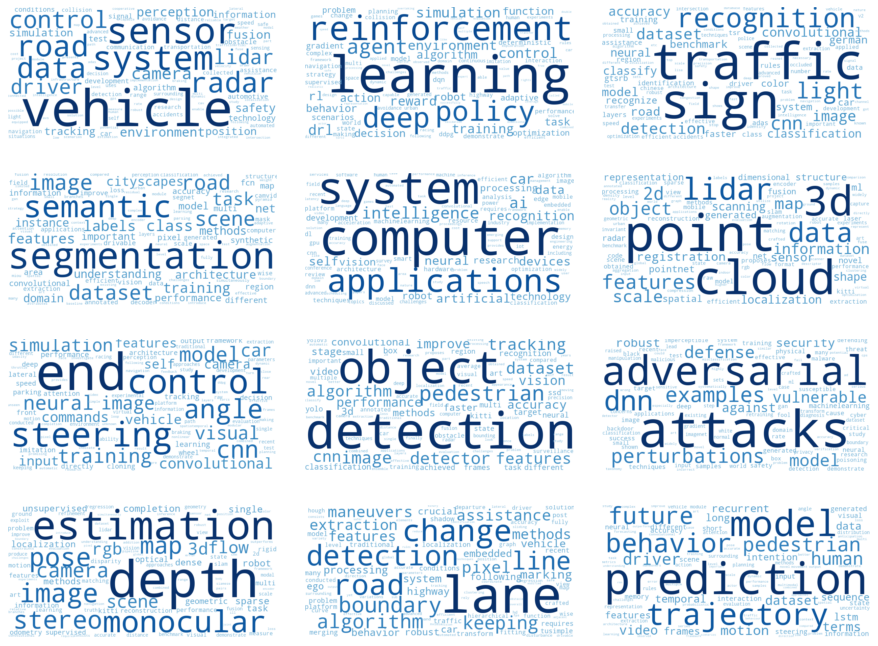

In [24]:
prepare_fig(2, 3)
for index in range(num_topics):
    mapping = dict()
    for i in np.argsort(topic2token[index])[::-1][:100]:
        if topic2token[index,i] > 0:
            mapping[dic[i]] = topic2token[index,i]
    
    def get_color(word, **kwargs):
        weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
        r, g, b = plt.get_cmap('Blues')(weight)[:3]
        return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))
    
    wc = WordCloud(
        prefer_horizontal=True,
        max_font_size=75,
        #width=395,
        #height=250,
        scale=2,
        background_color='white', 
        color_func=get_color, 
        relative_scaling=0.5)
    wc.fit_words(mapping)
    
    print('Topic {} ({})'.format(index, labels[index]))
    plt.subplot(4, 3, index + 1)
    plt.imshow(wc.to_array(), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.show()


## Visualization

/home/jingjieyeo/anaconda3/envs/pyblio/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1915 samples in 0.000s...
[t-SNE] Computed neighbors for 1915 samples in 0.131s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1915
[t-SNE] Computed conditional probabilities for sample 1915 / 1915
[t-SNE] Mean sigma: 0.114923
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.975792
[t-SNE] KL divergence after 1000 iterations: 1.140585


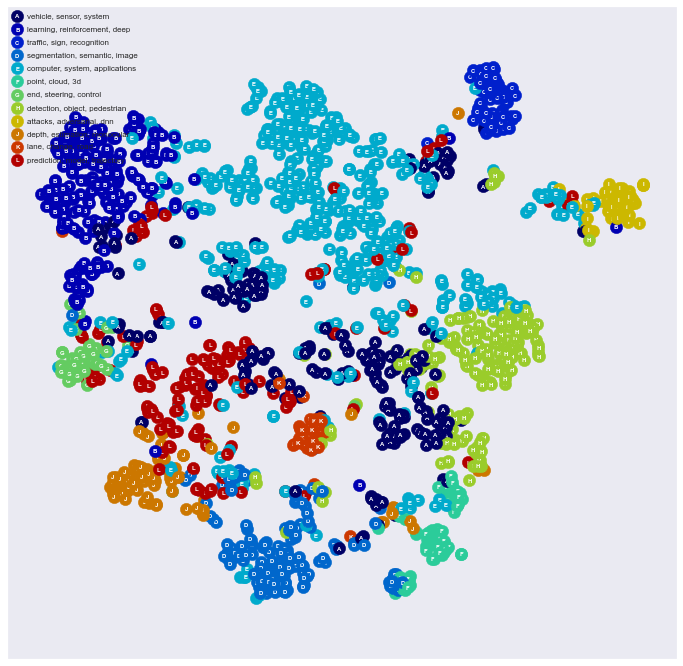

In [25]:
import sklearn.manifold
import sklearn.metrics.pairwise
from sklearn.decomposition import TruncatedSVD

def draw_dot(p, t, zorder=0):
    color = plt.get_cmap('jet')(float(t) / num_topics)
    color = 0.8 * np.array(color)[:3]
    
    plt.scatter(
        p[0], 
        p[1],
        s=150,
        c=[color],
        marker='o',
        linewidth=0.5,
        zorder=zorder)
    
    plt.text(
        p[0], 
        p[1],
        labels[t],
        fontsize=6,
        color='1',
        va='center',
        ha='center',
        fontweight='bold',
        zorder=zorder + 1)

# Lower dimensionality of original frequency matrix to improve cosine distances for visualization
reduced_matrix = TruncatedSVD(
    n_components=10, 
    random_state=seed
).fit_transform(tfidf_matrix)

# Learn model
model = sklearn.manifold.TSNE(
    verbose=True,
    metric='cosine',
    random_state=vis_seed,
    perplexity=20)
pos = model.fit_transform(reduced_matrix)

# Rotate visualization
theta = np.deg2rad(vis_angle + 60)
R = np.array([[np.cos(theta), np.sin(theta)], 
              [-np.sin(theta), np.cos(theta)]])
pos = np.dot(pos, R)

# Resize so xy-position is between 0.05 and 0.95
pos -= (np.amin(pos, axis=0) + np.amax(pos, axis=0)) / 2
pos /= np.amax(np.abs(pos))
pos = (pos * 0.5) + 0.5
pos = (pos * 0.9) + 0.05

prepare_fig(2, 4)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, 1)
zorder = 0

# Draw dots
for i in np.random.permutation(len(doc2topic)):
    topic_id = np.argmax(doc2topic[i])
    draw_dot(pos[i], topic_id, zorder)
    zorder += 2

# Draw legend
for i in range(num_topics):    
    y = 0.985 - i * 0.02
    label = ', '.join(dic[w] for w in np.argsort(topic2token[i])[::-1][:3])

    draw_dot([0.015, y], i)
    plt.text(0.03, y, label, ha='left', va='center', fontsize=8, zorder=zorder)
    zorder += 1

plt.show()

In [26]:
def on_select(i):
    p = papers[i]
    print(p.title)
    
    prepare_fig(1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(pos.T[0], pos.T[1], c='.5')
    plt.scatter(pos[i,0], pos[i,1], c='0', marker='x')
    plt.show()

    top_words = np.argsort(topic2token, axis=1)[:,::-1]
    ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:3])) for l, w in zip(labels, top_words)]
    
    fig = prepare_fig(1, 2)
    plt.barh(range(num_topics), doc2topic[i])
    plt.xlim(0, 1)
    plt.ylim(num_topics, -1)
    plt.yticks(range(num_topics), ticks)
    plt.show()
    
    print(p.abstract)

options = sorted([((p.title or '').strip()[:50], i) for i, p in enumerate(papers)])
widget = widgets.interactive(on_select, i=options)
widget.children[-1].layout.height = '2000px'
widget

interactive(children=(Dropdown(description='i', options=(('"Why did you do that?" Explainable intelligent rob'…